In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule
from uni2ts.eval_util.plot import plot_single

d:\Manchester\ERP\Code\AdvancedLLM\venv_units\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


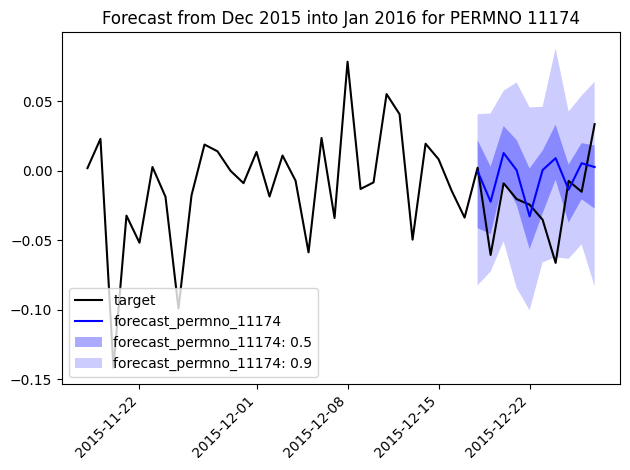

In [ ]:

# --- Load datasets ---
estimation_df = pd.read_csv("top50_estimation.csv")
outofsample_df = pd.read_csv("top50_outofsample.csv")

estimation_df["date"] = pd.to_datetime(estimation_df["date"])
outofsample_df["date"] = pd.to_datetime(outofsample_df["date"])

# --- Settings ---
permno = estimation_df["PERMNO"].iloc[0]  # choose one PERMNO
context_length = 30
prediction_length = 12
cutoff_date = pd.to_datetime("2015-12-31")

# --- Extract context window from estimation_df ---
train_df = estimation_df[
    (estimation_df["PERMNO"] == permno) &
    (estimation_df["date"] <= cutoff_date)
].sort_values("date").dropna()

context_df = train_df.tail(context_length)
context_df = context_df.set_index("date").rename(columns={"EXCESS_RET": "target"})
context_start = context_df.index[0]
context_target = context_df["target"].tolist()

# --- Create ListDataset for forecasting ---
train_ds = ListDataset(
    [{"start": context_start, "target": context_target}],
    freq="D"
)

# --- Load Moirai-MoE model ---
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-small"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=16,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

predictor = model.create_predictor(batch_size=16)
forecast_it = predictor.predict(train_ds)

# --- Extract forecast ---
forecast = next(forecast_it)

# --- Ground truth from out-of-sample test set ---
test_df = outofsample_df[
    outofsample_df["PERMNO"] == permno
].sort_values("date").dropna()

true_future = test_df["EXCESS_RET"].values[:prediction_length]
true_start = test_df["date"].values[0]

# --- Create label dict ---
label = {
    "target": true_future.tolist(),
    "start": pd.to_datetime(true_start)
}

# --- Plot forecast vs actual ---
test_series = list(train_ds)[0]

plot_single(
    test_series,
    label,
    forecast,
    context_length=context_length,
    name=f"forecast_permno_{permno}",
    show_label=True,
)

plt.title(f"Forecast from Dec 2015 into Jan 2016 for PERMNO {permno}")
plt.tight_layout()
plt.show()


In [18]:
avg_market_caps = (
    estimation_df.groupby('PERMNO')['MKT_CAP']
    .mean()
    .sort_values(ascending=False)
)

display((avg_market_caps))

top_n = max(1, int(len(avg_market_caps) * 0.1))

# Get top 10% PERMNOs
top_10_pct_permnos = avg_market_caps.sort_values(ascending=False).head(top_n).index.tolist()
# Get top 10% PERMNOs
min_10_pct_permnos = avg_market_caps.sort_values(ascending=True).head(top_n).index.tolist()

print("Top 10% PERMNOs by Market Cap:", top_10_pct_permnos)
print("Top 10% PERMNOs by Market Cap:", min_10_pct_permnos)

PERMNO
66093    1.525569e+11
76226    3.595558e+10
29647    2.611607e+10
78405    1.118811e+10
86339    1.055632e+10
81696    7.598825e+09
78840    7.298822e+09
80924    7.229011e+09
80089    6.775381e+09
85991    6.431542e+09
86218    6.293792e+09
68857    5.442989e+09
86996    4.300831e+09
85421    3.685955e+09
75049    3.578480e+09
83604    3.376114e+09
75104    3.168778e+09
63773    2.881172e+09
86869    2.862269e+09
75320    2.501611e+09
81043    1.828247e+09
80863    1.680567e+09
47677    1.403899e+09
87075    1.154848e+09
85425    8.716167e+08
87255    8.424249e+08
86560    8.418272e+08
66835    7.894038e+08
81740    7.215712e+08
81133    5.610599e+08
86155    5.065920e+08
80297    4.760784e+08
12173    4.420072e+08
83989    3.138813e+08
78971    3.003444e+08
87373    2.848481e+08
11174    2.269973e+08
87121    2.182236e+08
79033    2.037563e+08
87339    1.817428e+08
87342    1.671391e+08
86916    1.621737e+08
39731    5.290920e+07
Name: MKT_CAP, dtype: float64

Top 10% PERMNOs by Market Cap: [66093, 76226, 29647, 78405]
Top 10% PERMNOs by Market Cap: [39731, 86916, 87342, 87339]


In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

# --- Load data ---
estimation_df = pd.read_csv("top50_estimation.csv")
outofsample_df = pd.read_csv("top50_outofsample.csv")

estimation_df["date"] = pd.to_datetime(estimation_df["date"])
outofsample_df["date"] = pd.to_datetime(outofsample_df["date"])

# --- Forecast parameters ---
context_length = 30
prediction_length = 12
cutoff_date = pd.to_datetime("2015-12-31")

# --- Load Moirai-MoE model ---
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-small"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=16,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=16)

# --- Loop through all PERMNOs ---
permnos = sorted(outofsample_df["PERMNO"].unique())
results = []

for permno in permnos:
    try:
        # Get training context (last 30 days before 2016)
        train_df = estimation_df[
            (estimation_df["PERMNO"] == permno) &
            (estimation_df["date"] <= cutoff_date)
        ].sort_values("date").dropna(subset=["EXCESS_RET"])

        if len(train_df) < context_length:
            print(f"⏩ Skipping {permno} (not enough train data)")
            continue

        context_df = train_df.tail(context_length).copy()
        context_df = context_df.set_index("date").rename(columns={"EXCESS_RET": "target"})

        train_ds = ListDataset(
            [{
                "start": context_df.index[0],
                "target": context_df["target"].tolist()
            }],
            freq="D"
        )

        # Get true future (first 12 days of 2016)
        test_df = outofsample_df[outofsample_df["PERMNO"] == permno].sort_values("date")
        test_df = test_df.dropna(subset=["EXCESS_RET"])

        if len(test_df) < prediction_length:
            print(f" Skipping {permno} (not enough test data)")
            continue

        true_target = test_df["EXCESS_RET"].values[:prediction_length]

        # Forecast
        forecast_it = predictor.predict(train_ds)
        forecast = next(forecast_it)
        predicted = forecast.samples.mean(axis=0)

        # Metrics
        r2 = r2_score(true_target, predicted)
        mse = mean_squared_error(true_target, predicted)
        directional = np.mean(np.sign(np.diff(true_target)) == np.sign(np.diff(predicted)))

        # R2 out-of-sample (relative to context mean)
        context_mean = context_df["target"].mean()
        baseline = np.full_like(true_target, context_mean)
        r2_out = 1 - np.sum((true_target - predicted)**2) / np.sum((true_target - baseline)**2)

        results.append({
            "PERMNO": permno,
            "R2": r2,
            "R2_out_of_sample": r2_out,
            "MSE": mse,
            "Directional Accuracy": directional
        })

    except Exception as e:
        print(f"Error with PERMNO {permno}: {e}")


In [16]:
# --- Output results ---
results_df_all = pd.DataFrame(results)
print("\n Forecasting Results:")
print(results_df_all.round(3))


 Forecasting Results:
    PERMNO      R2  R2_out_of_sample    MSE  Directional Accuracy
0    11174  -0.146            -0.086  0.001                 0.545
1    12173  -0.189            -0.094  0.001                 0.636
2    29647   0.009             0.029  0.000                 0.636
3    39731  -1.269            -1.032  0.002                 0.455
4    47677  -0.424            -0.163  0.001                 0.636
5    63773  -0.751            -0.324  0.001                 0.182
6    66093  -0.139            -0.137  0.000                 0.364
7    66835  -0.074            -0.074  0.000                 0.545
8    68857  -0.780            -0.746  0.000                 0.727
9    75049   0.048             0.098  0.000                 0.636
10   75104  -0.005            -0.002  0.000                 0.818
11   75320  -0.454            -0.024  0.000                 0.273
12   76226  -0.271            -0.269  0.001                 0.273
13   78405   0.172             0.198  0.000          

In [20]:

summary_all = results_df_all.drop(columns='PERMNO').mean()

# Compute top 10% and bottom 10% based on R2
top_10pct = results_df_all[results_df_all["PERMNO"].isin(top_10_pct_permnos)]
bottom_10pct = results_df_all[results_df_all["PERMNO"].isin(min_10_pct_permnos)]
summary_top = top_10pct.drop(columns='PERMNO').mean()
summary_bottom = bottom_10pct.drop(columns='PERMNO').mean()

# Combine into one table
summary = pd.DataFrame({
    "All Stocks": summary_all,
    "Top 10%": summary_top,
    "Bottom 10%": summary_bottom
})

# Transpose the table for readability
summary_transposed = summary.T.round(3)
display(summary_transposed)

,R2,R2_out_of_sample,MSE,Directional Accuracy
All Stocks,-1.208,-0.869,0.001,0.495
Top 10%,-0.057,-0.045,0.000,0.500
Bottom 10%,-1.259,-1.193,0.002,0.432


In [11]:
final_result_mean = results_df_all.drop(columns=['PERMNO']).mean().to_frame().T

final_result_mean.index = ['Uni2TS']

display(final_result_mean.round(3))

,R2,R2_out_of_sample,MSE,Directional Accuracy
Uni2TS,-1.369,-0.966,0.002,0.493


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

# --- Load data ---
estimation_df = pd.read_csv("top50_estimation.csv")
outofsample_df = pd.read_csv("top50_outofsample.csv")

estimation_df["date"] = pd.to_datetime(estimation_df["date"])
outofsample_df["date"] = pd.to_datetime(outofsample_df["date"])

# --- Forecast parameters ---
context_length = 30
prediction_length = 12
cutoff_date = pd.to_datetime("2015-12-31")
ROLLING_WINDOWS = [5, 21, 252, 512]
TARGET = "EXCESS_RET"

# --- Load Moirai-MoE model ---
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-small"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=16,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=16)

# --- Forecasting loop for each rolling window ---
results = []

for window in ROLLING_WINDOWS:
    rolling_col = f"rolling_mean_{window}"

    for permno in sorted(outofsample_df["PERMNO"].unique()):
        try:
            # --- Prepare train ---
            train_df = estimation_df[
                (estimation_df["PERMNO"] == permno) & (estimation_df["date"] <= cutoff_date)
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(train_df) < context_length:
                continue

            context_df = train_df.tail(context_length).copy()
            context_df = context_df.set_index("date").rename(columns={TARGET: "target"})

            train_ds = ListDataset(
                [{"start": context_df.index[0], "target": context_df["target"].tolist()}],
                freq="D"
            )

            # --- Prepare test ---
            test_df = outofsample_df[
                outofsample_df["PERMNO"] == permno
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(test_df) < prediction_length:
                continue

            true_target = test_df[TARGET].values[:prediction_length]

            # --- Forecast ---
            forecast_it = predictor.predict(train_ds)
            forecast = next(forecast_it)
            predicted = forecast.samples.mean(axis=0)

            # --- Metrics ---
            r2 = r2_score(true_target, predicted)
            mse = mean_squared_error(true_target, predicted)
            directional = np.mean(np.sign(np.diff(true_target)) == np.sign(np.diff(predicted)))

            context_mean = context_df["target"].mean()
            r2_out = 1 - np.sum((true_target - predicted) ** 2) / np.sum((true_target - context_mean) ** 2)

            results.append({
                "Model": "Uni2TS-MoiraiMoE",
                "Rolling Window": window,
                "PERMNO": permno,
                "R2": r2,
                "R2_out_of_sample": r2_out,
                "MSE": mse,
                "Directional Accuracy": directional
            })

        except Exception as e:
            print(f"⚠️ Skipping PERMNO {permno} (window={window}): {e}")

# --- Results to DataFrame ---
uni2ts_df = pd.DataFrame(results)
uni2ts_avg_by_window = uni2ts_df.groupby("Rolling Window")[
    ["R2", "R2_out_of_sample", "MSE", "Directional Accuracy"]
].mean().reset_index()


c:\Users\fazlu\OneDrive - The University of Manchester\Pictures\Skripsi\ERP\Code\AdvancedLLM\venv_units\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
display(uni2ts_df)
uni2ts_df.to_csv("Results/moirai-moe-1.0.csv", index=False)
display(uni2ts_avg_by_window)

,Model,Rolling Window,PERMNO,R2,R2_out_of_sample,MSE,Directional Accuracy
0,Uni2TS-MoiraiMoE,5,11174,-0.341111,-0.200899,0.001152,0.545455
1,Uni2TS-MoiraiMoE,5,12173,-0.283604,-0.239651,0.000419,0.545455
2,Uni2TS-MoiraiMoE,5,29647,-0.055095,0.051288,0.000339,0.454545
3,Uni2TS-MoiraiMoE,5,39731,-0.115213,-0.105719,0.001389,0.545455
4,Uni2TS-MoiraiMoE,5,47677,-0.305367,-0.259524,0.000870,0.272727
...,...,...,...,...,...,...,...
158,Uni2TS-MoiraiMoE,512,86996,-0.320630,-0.052210,0.000190,0.545455
159,Uni2TS-MoiraiMoE,512,87075,-0.017312,0.006405,0.000219,0.727273
160,Uni2TS-MoiraiMoE,512,87121,-1.630931,-1.481546,0.000470,0.272727
161,Uni2TS-MoiraiMoE,512,87339,-0.210794,-0.186691,0.001000,0.454545


,Rolling Window,R2,R2_out_of_sample,MSE,Directional Accuracy
0,5,-0.552320,-0.461600,0.001812,0.579281
1,21,-1.374559,-1.248997,0.002710,0.473573
2,252,-2.044435,-1.311922,0.000919,0.445455
3,512,-0.994994,-0.834322,0.000653,0.503686


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

# --- Load data ---
estimation_df = pd.read_csv("top50_estimation.csv")
outofsample_df = pd.read_csv("top50_outofsample.csv")

estimation_df["date"] = pd.to_datetime(estimation_df["date"])
outofsample_df["date"] = pd.to_datetime(outofsample_df["date"])

# --- Forecast parameters ---
context_length = 30
prediction_length = 12
cutoff_date = pd.to_datetime("2015-12-31")
ROLLING_WINDOWS = [5, 21, 252, 512]
TARGET = "EXCESS_RET"

# --- Load Moirai-MoE model ---
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-base"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=16,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=16)

# --- Forecasting loop for each rolling window ---
results = []

for window in ROLLING_WINDOWS:
    rolling_col = f"rolling_mean_{window}"

    for permno in sorted(outofsample_df["PERMNO"].unique()):
        try:
            # --- Prepare train ---
            train_df = estimation_df[
                (estimation_df["PERMNO"] == permno) & (estimation_df["date"] <= cutoff_date)
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(train_df) < context_length:
                continue

            context_df = train_df.tail(context_length).copy()
            context_df = context_df.set_index("date").rename(columns={TARGET: "target"})

            train_ds = ListDataset(
                [{"start": context_df.index[0], "target": context_df["target"].tolist()}],
                freq="D"
            )

            # --- Prepare test ---
            test_df = outofsample_df[
                outofsample_df["PERMNO"] == permno
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(test_df) < prediction_length:
                continue

            true_target = test_df[TARGET].values[:prediction_length]

            # --- Forecast ---
            forecast_it = predictor.predict(train_ds)
            forecast = next(forecast_it)
            predicted = forecast.samples.mean(axis=0)

            # --- Metrics ---
            r2 = r2_score(true_target, predicted)
            mse = mean_squared_error(true_target, predicted)
            directional = np.mean(np.sign(np.diff(true_target)) == np.sign(np.diff(predicted)))

            context_mean = context_df["target"].mean()
            r2_out = 1 - np.sum((true_target - predicted) ** 2) / np.sum((true_target - context_mean) ** 2)

            results.append({
                "Model": "Uni2TS-MoiraiMoE",
                "Rolling Window": window,
                "PERMNO": permno,
                "R2": r2,
                "R2_out_of_sample": r2_out,
                "MSE": mse,
                "Directional Accuracy": directional
            })

        except Exception as e:
            print(f"⚠️ Skipping PERMNO {permno} (window={window}): {e}")

# --- Results to DataFrame ---
uni2ts_base_df = pd.DataFrame(results)
uni2ts_base_avg_by_window = uni2ts_df.groupby("Rolling Window")[
    ["R2", "R2_out_of_sample", "MSE", "Directional Accuracy"]
].mean().reset_index()

display(uni2ts_base_df)
uni2ts_base_df.to_csv("Results/moirai-moe-1.0-R-base.csv", index=False)
display(uni2ts_base_avg_by_window)

,Model,Rolling Window,PERMNO,R2,R2_out_of_sample,MSE,Directional Accuracy
0,Uni2TS-MoiraiMoE,5,11174,-1.744253,-1.457342,0.002357,0.363636
1,Uni2TS-MoiraiMoE,5,12173,-1.295405,-1.216806,0.000750,0.454545
2,Uni2TS-MoiraiMoE,5,29647,-0.226343,-0.102694,0.000395,0.545455
3,Uni2TS-MoiraiMoE,5,39731,-2.248583,-2.220927,0.004047,0.545455
4,Uni2TS-MoiraiMoE,5,47677,-0.026706,0.009351,0.000684,0.545455
...,...,...,...,...,...,...,...
158,Uni2TS-MoiraiMoE,512,86996,0.087149,0.272688,0.000131,0.636364
159,Uni2TS-MoiraiMoE,512,87075,-8.141413,-7.928299,0.001971,0.545455
160,Uni2TS-MoiraiMoE,512,87121,-0.115446,-0.052110,0.000199,0.363636
161,Uni2TS-MoiraiMoE,512,87339,-0.055604,-0.034590,0.000871,0.454545


,Rolling Window,R2,R2_out_of_sample,MSE,Directional Accuracy
0,5,-0.552320,-0.461600,0.001812,0.579281
1,21,-1.374559,-1.248997,0.002710,0.473573
2,252,-2.044435,-1.311922,0.000919,0.445455
3,512,-0.994994,-0.834322,0.000653,0.503686


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

# Load data
estimation_df = pd.read_csv("top50_estimation.csv")
outofsample_df = pd.read_csv("top50_outofsample.csv")
estimation_df["date"] = pd.to_datetime(estimation_df["date"])
outofsample_df["date"] = pd.to_datetime(outofsample_df["date"])

# Forecast parameters
context_length = 5
prediction_length = 252
cutoff_date = pd.to_datetime("2015-12-31")
ROLLING_WINDOWS = [5]
TARGET = "EXCESS_RET"

# Load model
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-base"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=16,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=16)

portfolio_data = []

for window in ROLLING_WINDOWS:
    rolling_col = f"rolling_mean_{window}"

    for permno in sorted(outofsample_df["PERMNO"].unique()):
        try:
            train_df = estimation_df[
                (estimation_df["PERMNO"] == permno) & (estimation_df["date"] <= cutoff_date)
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(train_df) < context_length:
                continue

            context_df = train_df.tail(context_length).copy()
            context_df = context_df.set_index("date").rename(columns={TARGET: "target"})

            train_ds = ListDataset(
                [{"start": context_df.index[0], "target": context_df["target"].tolist()}],
                freq="D"
            )

            test_df = outofsample_df[
                outofsample_df["PERMNO"] == permno
            ].sort_values("date").dropna(subset=[TARGET, rolling_col])

            if len(test_df) < prediction_length:
                continue

            true_target = test_df[TARGET].values[:prediction_length]
            forecast_dates = test_df["date"].iloc[:prediction_length].values

            forecast_it = predictor.predict(train_ds)
            forecast = next(forecast_it)
            predicted = forecast.samples.mean(axis=0)

            for i in range(prediction_length):
                portfolio_data.append({
                    "date": forecast_dates[i],
                    "PERMNO": permno,
                    "pred": predicted[i],
                    "EXCESS_RET": true_target[i]
                })

        except Exception as e:
            print(f"Error with PERMNO {permno}: {e}")
            continue

# Create DataFrame
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])


# Assign deciles
portfolio_df['rank'] = portfolio_df.groupby('date')['pred'].transform(
    lambda x: pd.qcut(x.rank(method='first'), q=4, labels=False, duplicates='drop')
)

# Long-Short daily returns
long_returns = portfolio_df[portfolio_df['rank'] == 3].groupby('date')['EXCESS_RET'].mean()
short_returns = portfolio_df[portfolio_df['rank'] == 0].groupby('date')['EXCESS_RET'].mean()
long_short = long_returns - short_returns

# With and without transaction cost
TRANSACTION_COST = 0.002
portfolio = pd.DataFrame({
    "long_ret": long_returns,
    "short_ret": short_returns,
    "long_short_ret": long_short
})
portfolio["long_short_cum"] = (1 + portfolio["long_short_ret"]).cumprod()
portfolio["long_short_ret_tc"] = portfolio["long_short_ret"] - TRANSACTION_COST * 2
portfolio["long_short_cum_tc"] = (1 + portfolio["long_short_ret_tc"]).cumprod()

# Save or display results
portfolio.to_csv("Results/uni2ts_portfolio.csv")
print(portfolio.head())



            long_ret  short_ret  long_short_ret  long_short_cum  \
date                                                              
2016-01-13 -0.012899  -0.028436        0.015537        1.015537   
2016-01-14 -0.001072   0.007525       -0.008597        1.006806   
2016-01-15 -0.022035  -0.027648        0.005614        1.012458   
2016-01-19 -0.013482  -0.001238       -0.012244        1.000061   
2016-01-20 -0.027112  -0.016077       -0.011035        0.989025   

            long_short_ret_tc  long_short_cum_tc  
date                                              
2016-01-13           0.011537           1.011537  
2016-01-14          -0.012597           0.998794  
2016-01-15           0.001614           1.000406  
2016-01-19          -0.016244           0.984155  
2016-01-20          -0.015035           0.969358  


Check 1 PERMNO

In [4]:
import os
import pandas as pd
import numpy as np
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

# === Params ===
TARGET = "EXCESS_RET"
context_length = 5 # using this directly
prediction_length = 1
start_date = pd.to_datetime("2016-01-01")
end_date   = pd.to_datetime("2024-12-31")
FREQ = "D"
permno_to_test = 11174      # <-- set to an existing PERMNO

# === Load & prep ===
main_df = pd.read_csv("main_data.csv")
main_df["date"] = pd.to_datetime(main_df["date"])
main_df = main_df.sort_values(["PERMNO", "date"]).reset_index(drop=True)
main_df[TARGET] = pd.to_numeric(main_df[TARGET], errors="coerce")
main_df["predicted_value"] = np.nan

# === Model ===
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-base"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=1,                 # <-- critical when context_length is small
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=16)

# === Single PERMNO with diagnostics ===
df_perm = main_df[main_df["PERMNO"] == permno_to_test].sort_values("date").reset_index()
idx_map = df_perm["index"]

debug_prints = 0
for pred_idx in range(len(df_perm)):
    pred_date = df_perm.loc[pred_idx, "date"]
    if pred_date < start_date or pred_date > end_date:
        continue

    # take the last <context_length> rows BEFORE the current row, by position
    left = pred_idx - context_length
    if left < 0:
        continue
    context_slice = df_perm.iloc[left:pred_idx]

    # require full context and no NaNs
    ctx_vals = context_slice[TARGET].astype(float)
    if ctx_vals.isna().any() or len(ctx_vals) < context_length:
        continue

    # optional: print first few contexts to verify inputs
    if debug_prints < 5:
        print(f"\nPERMNO {permno_to_test} @ {pred_date.date()} | context (len {len(ctx_vals)}):")
        print(ctx_vals.to_list())
        debug_prints += 1

    train_ds = ListDataset(
        [{"start": context_slice.loc[context_slice.index[0], "date"], 
          "target": ctx_vals.to_list()}],
        freq=FREQ,
    )

    try:
        forecast_it = predictor.predict(train_ds)
        forecast = next(forecast_it)
        yhat = float(forecast.samples.mean(axis=0)[0])
        main_df.loc[idx_map[pred_idx], "predicted_value"] = yhat
    except Exception as e:
        print(f"⚠️ Skipping {permno_to_test} at {pred_date.date()}: {e}")

# === Inspect results ===
out = main_df[main_df["PERMNO"] == permno_to_test][["date", TARGET, "predicted_value"]]
print("\nTop rows with predictions (non-null):")
print(out[out["predicted_value"].notna()].head(15))

# Optionally save just this PERMNO's predictions for quick look
os.makedirs("Results", exist_ok=True)
out.to_csv(f"Results/permno_{permno_to_test}_preds.csv", index=False)
print(f"\nSaved: Results/permno_{permno_to_test}_preds.csv")



PERMNO 11174 @ 2016-01-04 | context (len 5):
[-0.049512, 0.019442, 0.008276, -0.014276, -0.033671]

PERMNO 11174 @ 2016-01-05 | context (len 5):
[0.019442, 0.008276, -0.014276, -0.033671, 0.025478]

PERMNO 11174 @ 2016-01-06 | context (len 5):
[0.008276, -0.014276, -0.033671, 0.025478, 0.002192]

PERMNO 11174 @ 2016-01-07 | context (len 5):
[-0.014276, -0.033671, 0.025478, 0.002192, -0.060518]

PERMNO 11174 @ 2016-01-08 | context (len 5):
[-0.033671, 0.025478, 0.002192, -0.060518, -0.008925]

Top rows with predictions (non-null):
           date  EXCESS_RET  predicted_value
4025 2016-01-04    0.025478        -0.001369
4026 2016-01-05    0.002192         0.008149
4027 2016-01-06   -0.060518         0.008223
4028 2016-01-07   -0.008925        -0.003652
4029 2016-01-08   -0.020360         0.004210
4030 2016-01-11   -0.024381         0.002349
4031 2016-01-12   -0.035231        -0.009369
4032 2016-01-13   -0.066242        -0.020141
4033 2016-01-14   -0.007276        -0.023610
4034 2016-01-

In [ ]:
import os
import pandas as pd
import numpy as np
from gluonts.dataset.common import ListDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

# === Params ===
TARGET = "EXCESS_RET"
context_length = 5
prediction_length = 1
start_date = pd.to_datetime("2016-01-01")
end_date   = pd.to_datetime("2024-12-31")
FREQ = "D"

# === Load & prep ===
main_df = pd.read_csv("main_data.csv")
main_df["date"] = pd.to_datetime(main_df["date"])
main_df = main_df.sort_values(["PERMNO", "date"]).reset_index(drop=True)
main_df[TARGET] = pd.to_numeric(main_df[TARGET], errors="coerce")
main_df["predicted"] = np.nan   # placeholder column

# === Model ===
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-base"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=1,   # important for small context length
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=16)

# === Forecast for all PERMNOs ===
for permno, df_perm in main_df.groupby("PERMNO", sort=True):
    df_perm = df_perm.sort_values("date").reset_index()
    idx_map = df_perm["index"]

    contexts, write_indices = [], []
    for pred_idx in range(len(df_perm)):
        pred_date = df_perm.loc[pred_idx, "date"]
        if pred_date < start_date or pred_date > end_date:
            continue

        left = pred_idx - context_length
        if left < 0:
            continue

        context_slice = df_perm.iloc[left:pred_idx]
        ctx_vals = pd.to_numeric(context_slice[TARGET], errors="coerce").astype(float)

        if ctx_vals.isna().any() or len(ctx_vals) < context_length:
            continue

        contexts.append({
            "start": context_slice.loc[context_slice.index[0], "date"],
            "target": ctx_vals.to_list()
        })
        write_indices.append(int(idx_map[pred_idx]))

    if not contexts:
        continue

    ds = ListDataset(contexts, freq=FREQ)
    try:
        forecasts = predictor.predict(ds)
        for i, fc in enumerate(forecasts):
            yhat = float(fc.samples.mean(axis=0)[0])  # one-step ahead
            main_df.loc[write_indices[i], "predicted"] = yhat
    except Exception as e:
        print(f"⚠️ PERMNO {permno}: {e}")

display(main_df)

# === Save only evaluation slice with required columns ===
export_df = main_df.loc[
    (main_df["date"] >= start_date) & (main_df["date"] <= end_date),
    ["PERMNO", "date", TARGET, "predicted"]
].copy()

os.makedirs("Results", exist_ok=True)
export_path = "Results/uni2ts_predictions_5_new.csv"
export_df.to_csv(export_path, index=False)

print(f"✅ Exported evaluation slice with PERMNO/date/{TARGET}/predicted_value to: {export_path}")
display(export_df.head(20))

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,Category,rf,EXCESS_RET,...,rolling_mean_5,rolling_mean_21,rolling_mean_252,rolling_mean_512,EXCESS_RET_lag_1,EXCESS_RET_lag_2,EXCESS_RET_lag_3,EXCESS_RET_lag_4,EXCESS_RET_lag_5,predicted
0,11174,2000-01-03,4840.0,CROWN GROUP INC,5.10938,0.034810,9711.0,Telecom & Cable,0.00021,0.034600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11174,2000-01-04,4840.0,CROWN GROUP INC,5.00000,-0.021407,9711.0,Telecom & Cable,0.00021,-0.021617,...,NaN,NaN,NaN,NaN,0.034600,NaN,NaN,NaN,NaN,NaN
2,11174,2000-01-05,4840.0,CROWN GROUP INC,4.87500,-0.025000,9711.0,Telecom & Cable,0.00021,-0.025210,...,NaN,NaN,NaN,NaN,-0.021617,0.034600,NaN,NaN,NaN,NaN
3,11174,2000-01-06,4840.0,CROWN GROUP INC,5.18750,0.064103,9711.0,Telecom & Cable,0.00021,0.063893,...,NaN,NaN,NaN,NaN,-0.025210,-0.021617,0.034600,NaN,NaN,NaN
4,11174,2000-01-07,4840.0,CROWN GROUP INC,4.75000,-0.084337,9711.0,Telecom & Cable,0.00021,-0.084547,...,NaN,NaN,NaN,NaN,0.063893,-0.025210,-0.021617,0.034600,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314445,87344,2024-12-24,7370.0,SIFY TECHNOLOGIES LTD,3.02000,0.016835,11779.0,Internet & Software,0.00017,0.016665,...,-0.011826,-0.005351,-0.002356,0.000115,-0.000170,0.023968,-0.070683,-0.034226,0.021982,0.001923
314446,87344,2024-12-26,7370.0,SIFY TECHNOLOGIES LTD,3.19000,0.056291,11779.0,Internet & Software,0.00017,0.056121,...,-0.012889,-0.004832,-0.002185,0.000162,0.016665,-0.000170,0.023968,-0.070683,-0.034226,0.005730
314447,87344,2024-12-27,7370.0,SIFY TECHNOLOGIES LTD,3.16000,-0.009404,11779.0,Internet & Software,0.00017,-0.009574,...,0.005180,-0.003422,-0.001940,0.000316,0.056121,0.016665,-0.000170,0.023968,-0.070683,0.015319
314448,87344,2024-12-30,7370.0,SIFY TECHNOLOGIES LTD,2.89000,-0.085443,11779.0,Internet & Software,0.00017,-0.085613,...,0.017402,-0.005107,-0.001869,0.000357,-0.009574,0.056121,0.016665,-0.000170,0.023968,0.016099


✅ Exported evaluation slice with PERMNO/date/EXCESS_RET/predicted_value to: Results/uni2ts_predictions_21_new.csv


,PERMNO,date,EXCESS_RET,predicted
4025,11174,2016-01-04,0.025478,0.014883
4026,11174,2016-01-05,0.002192,0.019260
4027,11174,2016-01-06,-0.060518,0.022006
4028,11174,2016-01-07,-0.008925,0.018895
4029,11174,2016-01-08,-0.020360,0.013902
4030,11174,2016-01-11,-0.024381,0.012207
4031,11174,2016-01-12,-0.035231,0.013587
4032,11174,2016-01-13,-0.066242,0.007182
4033,11174,2016-01-14,-0.007276,0.014601
4034,11174,2016-01-15,-0.015117,0.011157


In [6]:
display(main_df)

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,Category,rf,EXCESS_RET,...,rolling_mean_5,rolling_mean_21,rolling_mean_252,rolling_mean_512,EXCESS_RET_lag_1,EXCESS_RET_lag_2,EXCESS_RET_lag_3,EXCESS_RET_lag_4,EXCESS_RET_lag_5,predicted_value
0,11174,2000-01-03,4840.0,CROWN GROUP INC,5.10938,0.034810,9711.0,Telecom & Cable,0.00021,0.034600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11174,2000-01-04,4840.0,CROWN GROUP INC,5.00000,-0.021407,9711.0,Telecom & Cable,0.00021,-0.021617,...,NaN,NaN,NaN,NaN,0.034600,NaN,NaN,NaN,NaN,NaN
2,11174,2000-01-05,4840.0,CROWN GROUP INC,4.87500,-0.025000,9711.0,Telecom & Cable,0.00021,-0.025210,...,NaN,NaN,NaN,NaN,-0.021617,0.034600,NaN,NaN,NaN,NaN
3,11174,2000-01-06,4840.0,CROWN GROUP INC,5.18750,0.064103,9711.0,Telecom & Cable,0.00021,0.063893,...,NaN,NaN,NaN,NaN,-0.025210,-0.021617,0.034600,NaN,NaN,NaN
4,11174,2000-01-07,4840.0,CROWN GROUP INC,4.75000,-0.084337,9711.0,Telecom & Cable,0.00021,-0.084547,...,NaN,NaN,NaN,NaN,0.063893,-0.025210,-0.021617,0.034600,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314445,87344,2024-12-24,7370.0,SIFY TECHNOLOGIES LTD,3.02000,0.016835,11779.0,Internet & Software,0.00017,0.016665,...,-0.011826,-0.005351,-0.002356,0.000115,-0.000170,0.023968,-0.070683,-0.034226,0.021982,0.011252
314446,87344,2024-12-26,7370.0,SIFY TECHNOLOGIES LTD,3.19000,0.056291,11779.0,Internet & Software,0.00017,0.056121,...,-0.012889,-0.004832,-0.002185,0.000162,0.016665,-0.000170,0.023968,-0.070683,-0.034226,0.005625
314447,87344,2024-12-27,7370.0,SIFY TECHNOLOGIES LTD,3.16000,-0.009404,11779.0,Internet & Software,0.00017,-0.009574,...,0.005180,-0.003422,-0.001940,0.000316,0.056121,0.016665,-0.000170,0.023968,-0.070683,0.036292
314448,87344,2024-12-30,7370.0,SIFY TECHNOLOGIES LTD,2.89000,-0.085443,11779.0,Internet & Software,0.00017,-0.085613,...,0.017402,-0.005107,-0.001869,0.000357,-0.009574,0.056121,0.016665,-0.000170,0.023968,0.032050


In [24]:
df = pd.read_csv("Results/uni2ts_predictions_5_new.csv")
display(df)
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

export_path = "Results/uni2ts_predictions_5_new.csv"
df.to_csv(export_path, index=False)

,PERMNO,date,EXCESS_RET,predicted
0,11174,04/01/2016,0.025478,0.001030
1,11174,05/01/2016,0.002192,0.019545
2,11174,06/01/2016,-0.060518,0.009723
3,11174,07/01/2016,-0.008925,-0.001282
4,11174,08/01/2016,-0.020360,0.003059
...,...,...,...,...
113195,87344,24/12/2024,0.016665,0.005839
113196,87344,26/12/2024,0.056121,0.007711
113197,87344,27/12/2024,-0.009574,0.034208
113198,87344,30/12/2024,-0.085613,0.028785


In [ ]:
import pandas as pd
import os

# === Files ===
files = [
    "uni2ts_predictions_5.csv",
    "uni2ts_predictions_21.csv",
    "uni2ts_predictions_252.csv",
    "uni2ts_predictions_512.csv"
]
output_path = "Results/uni2ts_merged_predictions.csv"

merged_df = None

for file in files:
    print(file)
    window = file.split("_")[-1].replace(".csv", "")
    print(window)
    pred_col_name = f"unit2ts_{window}"

    df = pd.read_csv(f"Results/{file}")
    df.columns = [col.strip().upper() for col in df.columns]  # Normalize

    # Rename robustly
    df = df.rename(columns={
        "TRUE": "EXCESS_RET",
        "PREDICTED": pred_col_name
    })
    df["date"] = pd.to_datetime(df["DATE"], format="%Y-%m-%d", errors="coerce")  # handle upper-case
    print(df["date"].isna().sum())
    
    df = df[["PERMNO", "date", "EXCESS_RET", pred_col_name]]

    if merged_df is None:
        merged_df = df
    else:
        merged_df = merged_df.merge(df, on=["PERMNO", "date", "EXCESS_RET"], how="inner")

# === Save ===
os.makedirs("Results", exist_ok=True)
merged_df.to_csv(output_path, index=False)
print(f"✅ Merged Unit2ts predictions saved to: {output_path}")
print(merged_df.head())


uni2ts_predictions_5_new.csv
5
0
uni2ts_predictions_21_new.csv
21
0
uni2ts_predictions_252_new.csv
252
0
uni2ts_predictions_512_new.csv
512
0
✅ Merged Unit2ts predictions saved to: Results/uni2ts_merged_predictions_new.csv
   PERMNO       date  EXCESS_RET  unit2ts_5  unit2ts_21  unit2ts_252  \
0   11174 2016-01-04    0.025478   0.001030    0.014883     0.007511   
1   11174 2016-01-05    0.002192   0.019545    0.019260     0.007842   
2   11174 2016-01-06   -0.060518   0.009723    0.022006     0.009646   
3   11174 2016-01-07   -0.008925  -0.001282    0.018895     0.005178   
4   11174 2016-01-08   -0.020360   0.003059    0.013902     0.007630   

   unit2ts_512  
0     0.005008  
1     0.006862  
2     0.007276  
3     0.004460  
4     0.003904  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import re

# Load predictions
df = pd.read_csv("Results/uni2ts_merged_predictions.csv")

# Directional metrics
def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

def directional_up_accuracy(y_true, y_pred):
    mask = y_true > 0
    return np.mean(np.sign(y_pred[mask]) == 1) if mask.any() else np.nan

def directional_down_accuracy(y_true, y_pred):
    mask = y_true < 0
    return np.mean(np.sign(y_pred[mask]) == -1) if mask.any() else np.nan

# Identify model prediction columns
base_cols = {"PERMNO", "date", "EXCESS_RET"}
pred_cols = [col for col in df.columns if col not in base_cols]
results_by_permno = []

for model_col in pred_cols:
    match = re.search(r'_(\d+)$', model_col)
    rolling_window = int(match.group(1)) if match else None
    model_name = model_col.rsplit("_", 1)[0]

    for permno, group in df.groupby("PERMNO"):
        y_true = group["EXCESS_RET"]
        y_pred = group[model_col]

        valid = y_true.notna() & y_pred.notna()
        y_true = y_true[valid]
        y_pred = y_pred[valid]

        if len(y_true) < 5:
            continue

        results_by_permno.append({
            'Model': model_name,
            'Rolling Window': rolling_window,
            'PERMNO': permno,
            'R2': r2_score(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'Directional Accuracy': directional_accuracy(y_true, y_pred),
            'Directional Up': directional_up_accuracy(y_true, y_pred),
            'Directional Down': directional_down_accuracy(y_true, y_pred)
        })

# Create DataFrame
results_by_permno_df = pd.DataFrame(results_by_permno)
results_by_permno_df.to_csv("Results/uni2ts_metrics_by_permno.csv", index=False)
display(results_by_permno_df)

,Model,Rolling Window,PERMNO,R2,MSE,MAE,Directional Accuracy,Directional Up,Directional Down
0,unit2ts,5,11174,-0.439039,0.001546,0.026794,0.502196,0.847637,0.148221
1,unit2ts,5,20512,-0.459763,0.000444,0.014649,0.517901,0.881530,0.114788
2,unit2ts,5,29647,-0.353964,0.000188,0.009014,0.521376,0.869484,0.139896
3,unit2ts,5,39731,-0.510303,0.002766,0.036696,0.468765,0.850505,0.118980
4,unit2ts,5,40125,-0.438595,0.001610,0.024372,0.500244,0.850760,0.129162
...,...,...,...,...,...,...,...,...,...
195,unit2ts,512,86929,-0.268556,0.001007,0.022810,0.489776,0.999006,0.000958
196,unit2ts,512,86996,-0.274521,0.000390,0.014489,0.530682,0.998153,0.000000
197,unit2ts,512,87075,-0.246892,0.000549,0.016800,0.526829,0.998152,0.000000
198,unit2ts,512,87179,-0.260139,0.000589,0.017267,0.500242,0.999032,0.000000


In [ ]:
# Aggregate by Model & Rolling Window
results_overall_df = results_by_permno_df.groupby(
    ['Model', 'Rolling Window']
).agg({
    'R2': 'mean',
    'MSE': 'mean',
    'MAE': 'mean',
    'Directional Accuracy': 'mean',
    'Directional Up': 'mean',
    'Directional Down': 'mean'
}).reset_index()

# Save to CSV
results_overall_df.to_csv("Results/uni2ts_metrics_overall.csv", index=False)
print("✅ Saved: Results/uni2ts_metrics_overall.csv")
display(results_overall_df)


✅ Saved: Results/uni2ts_metrics_overall.csv


,Model,Rolling Window,R2,MSE,MAE,Directional Accuracy,Directional Up,Directional Down
0,unit2ts,5,-0.463136,0.001673,0.023219,0.497338,0.844872,0.147368
1,unit2ts,21,-0.296151,0.001477,0.022251,0.501550,0.982828,0.017179
2,unit2ts,252,-0.254507,0.001406,0.022267,0.501439,0.998791,0.001131
3,unit2ts,512,-0.243662,0.001392,0.022149,0.501613,0.999008,0.001266
